In [ ]:
%pip install "textblob==0.17.1" "s3fs==2023.12.1"

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
from pyspark.ml.feature import RegexTokenizer, HashingTF, IDF
from pyspark.sql.functions import concat, col
from textblob import TextBlob
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, isnan, when, count, udf
sc.setLogLevel("ERROR")
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import io
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Binarizer

In [ ]:
file_path_list = ['s3a://4130semesterprojectas/raw/part-00000-tid-693570239219521015-7c35c41b-2dfb-4b25-befe-9c96d3cfe97b-295-1-c000.snappy.parquet', 's3a://4130semesterprojectas/raw/part-00000-tid-8723679316915364511-daad138e-0a4e-47c1-8031-aa906356dee3-267-1-c000.snappy.parquet', 's3a://4130semesterprojectas/raw/part-00001-tid-693570239219521015-7c35c41b-2dfb-4b25-befe-9c96d3cfe97b-296-1-c000.snappy.parquet', 's3a://4130semesterprojectas/raw/part-00001-tid-8723679316915364511-daad138e-0a4e-47c1-8031-aa906356dee3-268-1-c000.snappy.parquet', 's3a://4130semesterprojectas/raw/part-00002-tid-693570239219521015-7c35c41b-2dfb-4b25-befe-9c96d3cfe97b-297-1-c000.snappy.parquet', 's3a://4130semesterprojectas/raw/part-00002-tid-8723679316915364511-daad138e-0a4e-47c1-8031-aa906356dee3-269-1-c000.snappy.parquet']


In [ ]:
rdf = spark.read.parquet(file_path_list[0])

In [ ]:
rdf = rdf.sample(False, 0.01)

In [ ]:
columns_to_drop = ["marketplace", "product_parent", "product_title"]
rdf = rdf.drop(*columns_to_drop)
rdf = rdf[(rdf['verified_purchase'] == 'Y') & (rdf['helpful_votes'] > '1')]
rdf = rdf.withColumn("full_review", concat(col("review_headline"), col("review_body")))
rdf = rdf.withColumn("star_rating", col("star_rating").cast("double"))

In [ ]:
# Check the counts of words in the full_review
rdf = rdf.withColumn('full_review_word_count', size(split(col('full_review'), ' ')))
rdf.select('full_review_word_count').summary("count", "min", "max", "mean").show()


+-------+----------------------+
|summary|full_review_word_count|
+-------+----------------------+
|  count|                   532|
|    min|                     2|
|    max|                   359|
|   mean|     62.36278195488722|
+-------+----------------------+



In [ ]:
# Remove records where word count in full_review is too low
rdf = rdf.where(col('full_review_word_count') > 0)

In [ ]:
regexTokenizer = RegexTokenizer(inputCol="full_review", outputCol="words", pattern="\\w+", gaps=False)

# Apply the hashing trick and transform to TF-IDF
hasher = HashingTF(numFeatures=4096, inputCol="words", outputCol="word_features")
idf = IDF(inputCol='word_features', outputCol="idffeatures", minDocFreq=1)
binarizer = Binarizer(threshold=3.0, inputCol="star_rating", outputCol="binary_rating")


In [ ]:
feature_col = "idffeatures"
label_col = "binary_rating"

lr = LogisticRegression(labelCol= label_col, featuresCol= feature_col)

In [ ]:
pipeline = Pipeline(stages=[regexTokenizer, hasher, idf, binarizer])

In [ ]:
rdf = pipeline.fit(rdf).transform(rdf)

In [ ]:
def sentiment_analysis(some_text):
    sentiment = TextBlob(some_text).sentiment.polarity
    return sentiment
    
sentiment_analysis_udf = udf(sentiment_analysis, DoubleType())

rdf = rdf.withColumn("sentiment_score",
 sentiment_analysis_udf( rdf['full_review'] ))


In [ ]:
train_data, test_data = rdf.randomSplit([0.8, 0.2], seed=42)

In [ ]:
model = lr.fit(train_data)

In [ ]:
test_results = model.transform(test_data)


In [ ]:
s3_bucket = "s3://4130semesterprojectas/trusted/"
test_results.write.mode("overwrite").parquet(s3_bucket)


In [ ]:
cm = test_results.groupby('binary_rating').pivot('prediction').count().fillna(0).collect()
def calculate_recall_precision(cm):
 tn = cm[0][1] # True Negative
 fp = cm[0][2] # False Positive
 fn = cm[1][1] # False Negative
 tp = cm[1][2] # True Positive
 precision = tp / ( tp + fp )
 recall = tp / ( tp + fn )
 accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
 f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
 return accuracy, precision, recall, f1_score
print( calculate_recall_precision(cm) )

(0.7317073170731707, 0.8545454545454545, 0.7704918032786885, 0.810344827586207)


Out[18]: Text(0.5, 1.0, 'Helpful Votes Freq')

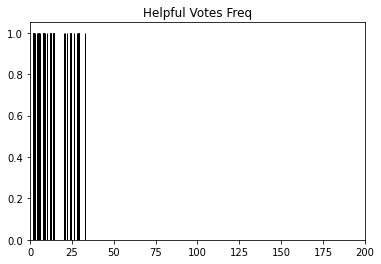

In [ ]:
helpful_votes_df = test_results.groupby('helpful_votes').count().sort('helpful_votes').toPandas()

# Bar Plot of food and count
values = helpful_votes_df['helpful_votes']
plt.hist(values, bins=1000, color='green', edgecolor='black')
plt.xlim(0, 200)
# fig.tight_layout()
plt.title("Helpful Votes Freq")
#plt.savefig("frequency_food_ordered.png")

In [ ]:
img_data = io.BytesIO()
plt.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://4130semesterprojectas/model/freq.png', 'wb') as f:
 f.write(img_data.getbuffer())

<Figure size 432x288 with 0 Axes>

In [ ]:
#display(Image(data=img_data.getvalue()))

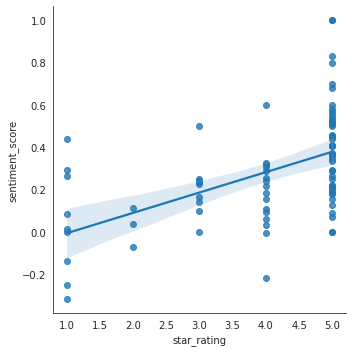

In [ ]:
import seaborn as sns
# Take the order total column and convert to a Pandas dataframe
df = test_results.select('star_rating', 'sentiment_score').toPandas() 

# Set the style for Seaborn plots
sns.set_style("white")

# Create the relationship plot
lmp = sns.lmplot(x='star_rating', y='sentiment_score', data=df)

In [ ]:
img_data = io.BytesIO()
lmp.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://4130semesterprojectas/model/lmplot.png', 'wb') as f:
 f.write(img_data.getbuffer())

In [ ]:
#display(Image(data=img_data.getvalue()))

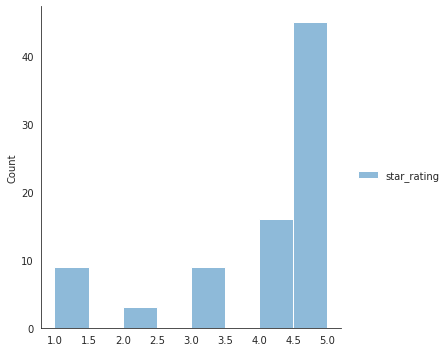

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Take the order total column and convert to a Pandas dataframe
df1 = test_results.select('star_rating').toPandas() 
# Set the style for Seaborn plots
sns.set_style("white")
# Create the distribution plot
distribution_plot = sns.displot(df1)

In [ ]:
img_data = io.BytesIO()
distribution_plot.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://4130semesterprojectas/model/distribution_plot.png', 'wb') as f:
 f.write(img_data.getbuffer())

In [ ]:
from pyspark.ml.stat import Correlation
vector_column = "correlation_features"
numeric_columns  = ["sentiment_score", "star_rating", "helpful_votes", "binary_rating"]

assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(rdf).select(vector_column)

matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns,index=numeric_columns)

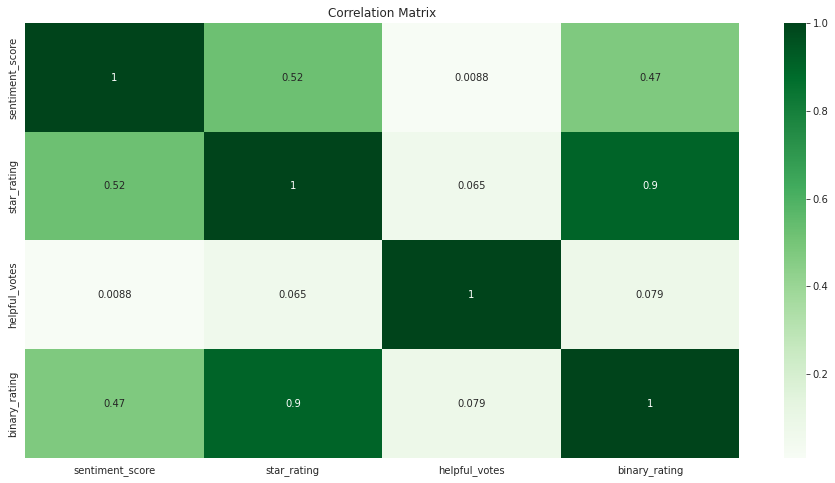

In [ ]:
sns.set_style("white")
# Crate the plot using Seaborn
# plt.figure(figsize=(16,5))
fig, ax = plt.subplots(figsize = (16,8))
hm = sns.heatmap(correlation_matrix_df, xticklabels=correlation_matrix_df.columns.values, yticklabels=correlation_matrix_df.columns.values, cmap="Greens", annot=True, ax=ax)
plt.title('Correlation Matrix')

# Get the content of the current figure
figure = hm.get_figure()


In [ ]:
img_data = io.BytesIO()
# Write the figure to the buffer
figure.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://4130semesterprojectas/model/correlation_plot.png', 'wb') as f:
   f.write(img_data.getbuffer())

In [ ]:
#display(Image(data=img_data.getvalue()))